In [1]:
# import the required packages (please check! you might not need all)
#test
import numpy as np
import pandas as pd
from datetime import datetime, timezone
from matplotlib.dates import date2num, num2date
from os.path import join
import matplotlib.pyplot as plt
from matplotlib.path import Path
import glob
import os
import time
import matplotlib.dates as md
from netCDF4 import Dataset # pylint: disable=no-name-in-module
from sklearn.metrics import mean_absolute_error
from scipy import stats
from sklearn import linear_model

In [2]:
def read_csv_raw_datalakes(prof_name,col_names):
    df_raw = pd.read_csv(prof_name)
    df_raw = df_raw[col_names]
    df_raw = df_raw.set_index('x')
    df_raw = df_raw.sort_index()
    
    return df_raw

# Read LXP skin temperatures

In [3]:
input_folder = './Data/Geneva/skin_temp/LXP_skin'
input_folder= os.path.abspath(input_folder)

os.chdir(input_folder)

# Create a list with all the files
path = os.getcwd()
allfiles = os.listdir(path)
tempfiles = [f for f in allfiles if f[-4:] == ".csv"]
tempfiles = [f for f in tempfiles if f[0] != "~"] # in case there is an open file
fileslist = tempfiles

C:\Users\claud\Documents\Geographie-Studium-6. Semester\ESS374\03_GitHub\WASY
C:\Users\claud\Documents\Geographie-Studium-6. Semester\ESS374\03_GitHub\WASY\Data\Geneva\skin_temp\LXP_skin


In [4]:
# I suggest you open one csv file together with the metadata to see what is inside the files
ii = 0
col_names = ['x','y','y1','y2','y3','y4'] # x: time; y: Skin temp; y1: Rel hum; y2: Solar irrad; y3: wind speed; y4: wind dir; y5: rainfal; y6: air press
df_lxp_skin = read_csv_raw_datalakes(fileslist[ii],col_names)

for ii in range(1,len(fileslist)):
    df_lxp_skin = df_lxp_skin.append(read_csv_raw_datalakes(fileslist[ii],col_names))
df_lxp_skin = df_lxp_skin.sort_index()
df_lxp_skin = df_lxp_skin[['y']]

lxp_skin_datetime = np.array([datetime.fromtimestamp(ts) for ts in df_lxp_skin.index])
df_lxp_skin['datetime'] = lxp_skin_datetime
df_lxp_skin.columns = ['skin_temp','datetime']

C:\Users\claud\AppData\Local\Temp\ipykernel_15880\666793922.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_lxp_skin = df_lxp_skin.append(read_csv_raw_datalakes(fileslist[ii],col_names))
C:\Users\claud\AppData\Local\Temp\ipykernel_15880\666793922.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_lxp_skin = df_lxp_skin.append(read_csv_raw_datalakes(fileslist[ii],col_names))
C:\Users\claud\AppData\Local\Temp\ipykernel_15880\666793922.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_lxp_skin = df_lxp_skin.append(read_csv_raw_datalakes(fileslist[ii],col_names))
C:\Users\claud\AppData\Local\Temp\ipykernel_15880\666793922.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

In [5]:
# check the DF
display(df_lxp_skin)

,skin_temp,datetime
x,,
1646708700,5.30,2022-03-08 04:05:00
1646709000,5.59,2022-03-08 04:10:00
1646709300,5.49,2022-03-08 04:15:00
1646709600,5.54,2022-03-08 04:20:00
1646709900,5.51,2022-03-08 04:25:00
...,...,...
1661324100,22.87,2022-08-24 08:55:00
1661324400,22.92,2022-08-24 09:00:00
1661324700,23.18,2022-08-24 09:05:00


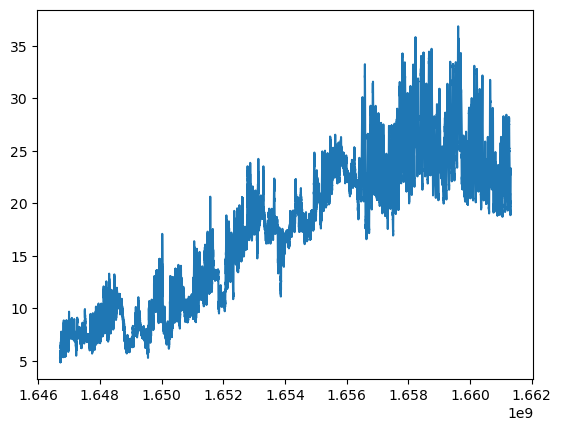

In [6]:
# just visually check the data and look for any obvious outliers
plt.plot(df_lxp_skin['skin_temp'])

# Read BUC skin and bulk temperatures

In [7]:
allfiles = './Data/Geneva/skin_temp/BUC_1m'
allfiles= os.path.abspath(allfiles)

# Create a list with all the files
path = os.chdir("../BUC_1m")
allfiles = os.listdir(path)

tempfiles = [f for f in allfiles if f[-3:] == ".nc"]
tempfiles = [f for f in tempfiles if f[0] != "~"] # in case there is an open file
fileslist = tempfiles

In [58]:
ii = 0
f = Dataset(fileslist[ii], 'r')
time_arr = np.array(f.variables['time'][:])
skintemp_arr = np.array(f.variables['WaterTemp0mKT15a_Avg'][:])
bulktemp_arr = np.array(f.variables['WaterTemp1m_Avg'][:])








f.close()

for ii in range(1,len(fileslist)):
    f = Dataset(fileslist[ii], 'r')
    time_arr = np.concatenate([time_arr,np.array(f.variables['time'][:])])
    skintemp_arr = np.concatenate([skintemp_arr,np.array(f.variables['WaterTemp0mKT15a_Avg'][:])])
    bulktemp_arr = np.concatenate([bulktemp_arr,np.array(f.variables['WaterTemp1m_Avg'][:])])

    #added parameters
    AirTemp10m_Avg=np.array(f.variables['AirTemp10m_Avg'][:])
    AirTemp7m_Avg=np.array(f.variables["AirTemp7m_Avg"][:])
    Mean_Wind_Speed=np.array(f.variables["Mean_Wind_Speed"][:])
    PTemp_C_Avg=np.array(f.variables["PTemp_C_Avg"][:])
    SolarWh_Tot=np.array(f.variables["SolarWh_Tot"][:]) #Solar Radiation
    BP_QFE=np.array(f.variables["BP_QFE"][:]) #Air pressure at station level
    BP_QFF=np.array(f.variables["BP_QFF"][:]) #Air pressure at sea level
    Rain_mm_Tot=np.array(f.variables["Rain_mm_Tot"][:]) #Rainfall in mm
    f.close()


In [60]:
#create dataframe from BUC Station:
df_buc_raw=pd.DataFrame(index=time_arr,columns=["skintemp_arr","bulktemp_arr","AirTemp10m_Avg","Mean_Wind_Speed","PTemp_C_Avg","SolarWh_Tot","BP_QFE","BP_QFF","Rain_mm_Tot"])

df_buc_raw["skintemp_arr"] = skintemp_arr
df_buc_raw["bulktemp_arr"] = bulktemp_arr
#df_buc_raw["AirTemp10m_Avg"] = AirTemp10m_Avg
#df_buc_raw["Mean_Wind_Speed"] = Mean_Wind_Speed
#df_buc_raw["PTemp_C_Avg"] = PTemp_C_Avg
#df_buc_raw["SolarWh_Tot"] = SolarWh_Tot
#df_buc_raw["BP_QFE"] = BP_QFE
#df_buc_raw["BP_QFF"] = BP_QFF
#df_buc_raw["Rain_mm_Tot"] = Rain_mm_Tot

df_buc_raw.describe()


,skintemp_arr,bulktemp_arr
count,50865.000000,49338.000000
mean,5.038842,13.872036
std,7.529386,5.967959
min,0.000000,0.285000
25%,0.000000,7.995000
50%,0.000000,12.910000
75%,8.710000,19.550000
max,46.300000,26.840000


In [9]:
df_buc_skin = pd.DataFrame(index=time_arr,columns=['skin_temp'])
df_buc_skin['skin_temp'] = skintemp_arr
df_buc_skin = df_buc_skin[(df_buc_skin['skin_temp']>4) & (df_buc_skin['skin_temp']<35)] #? Ask Fazel: Why do you filter >4 and <35?
# Answer: because Lake Geneva is not a frozen lake, and historical data does not show any value outside of [4,35] degree C range. 
# Actually, a better range for skin temperature would be [6, 30] for Lake Geneva. 
# However, this would be different for Aegerisee. The Temperature there can reach lower values (but obviously not below 0 degree)
buc_datetime = np.array([datetime.fromtimestamp(ts) for ts in df_buc_skin.index])
df_buc_skin['datetime'] = buc_datetime

################
df_buc_bulk = pd.DataFrame(index=time_arr,columns=['bulk_temp'])
df_buc_bulk['bulk_temp'] = bulktemp_arr
df_buc_bulk = df_buc_bulk[(df_buc_bulk['bulk_temp']>4) & (df_buc_bulk['bulk_temp']<35)]
buc_datetime = np.array([datetime.fromtimestamp(ts) for ts in df_buc_bulk.index])
df_buc_bulk['datetime'] = buc_datetime


In [10]:
display(df_buc_bulk.head())

,bulk_temp,datetime
1.480583e+09,9.29,2016-12-01 10:00:00
1.480586e+09,9.73,2016-12-01 11:00:00
1.480590e+09,9.72,2016-12-01 12:00:00
1.480594e+09,9.74,2016-12-01 13:00:00
1.480597e+09,9.79,2016-12-01 14:00:00


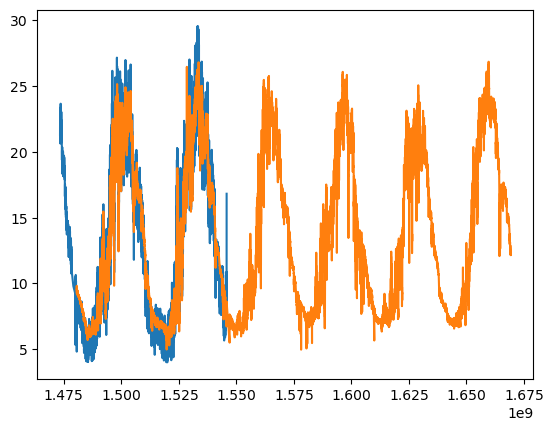

In [11]:
plt.plot(df_buc_skin['skin_temp'])
plt.hold = True
plt.plot(df_buc_bulk['bulk_temp'])

# Read Landsat data

In [25]:
input_folder = '../Landsat/'

#input_folder= os.path.abspath(input_folder)

df_buc_landsat = pd.read_csv(input_folder+'/'+'LANDSAT_ST_BUC_20020101_20221122_fixed.csv',sep=',',index_col=[0])
df_lxp_landsat = pd.read_csv(input_folder+'/'+'LANDSAT_ST_LXP_20220101_20221122_fixed.csv',sep=',',index_col=[0])

df_lxp_landsat['timestamp'] = [time.mktime(datetime.strptime(df_lxp_landsat['time_utc'].iloc[ii],"%Y-%m-%d %H:%M:%S").timetuple()) for ii in range(len(df_lxp_landsat))]
df_buc_landsat['timestamp'] = [time.mktime(datetime.strptime(df_buc_landsat['time_utc'].iloc[ii],"%Y-%m-%d %H:%M:%S").timetuple()) for ii in range(len(df_buc_landsat))]

In [26]:
df_lxp_landsat['time_utc'].iloc[0]

'2022-01-12 10:22:55'

In [27]:
display(df_lxp_landsat)

,ST,ST_unc,coverage,sensor,time_utc,time_utc+1,time_unix,timestamp
system:index,,,,,,,,
1_2_LC08_196027_20220112,4.374388,2.51,1.002077,LANDSAT_8,2022-01-12 10:22:55,2022-01-12 11:22:55,1641982975,1.641979e+09
1_2_LC08_196028_20220112,4.429076,2.41,1.001916,LANDSAT_8,2022-01-12 10:23:19,2022-01-12 11:23:19,1641982999,1.641979e+09
2_LC09_195028_20220113,6.698642,2.17,1.002077,LANDSAT_9,2022-01-13 10:17:08,2022-01-13 11:17:08,1642069028,1.642065e+09
1_2_LC08_195028_20220121,6.941321,2.14,1.002077,LANDSAT_8,2022-01-21 10:17:05,2022-01-21 11:17:05,1642760225,1.642757e+09
1_2_LC08_196027_20220128,6.322659,2.14,1.002077,LANDSAT_8,2022-01-28 10:22:49,2022-01-28 11:22:49,1643365369,1.643362e+09
...,...,...,...,...,...,...,...,...
1_1_2_LE07_195028_20220919,20.401484,2.12,1.002077,LANDSAT_7,2022-09-19 08:41:11,2022-09-19 09:41:11,1663576871,1.663570e+09
1_2_LC08_196028_20221011,16.607482,2.29,1.001916,LANDSAT_8,2022-10-11 10:23:36,2022-10-11 11:23:36,1665483816,1.665477e+09
1_2_LC08_196027_20221027,15.257364,2.65,1.002077,LANDSAT_8,2022-10-27 10:23:19,2022-10-27 11:23:19,1666866199,1.666859e+09


# compare the results

### LXP skin

In [28]:
df_insitu = df_lxp_skin.copy()
df_sat = df_lxp_landsat.copy()

##################
# find the matchups within +/- 2hours of Landsat overpass
timestamp_min = np.max([df_sat['timestamp'].iloc[0],df_insitu.index[0]])-3600*2
timestamp_max = np.min([df_sat['timestamp'].iloc[-1],df_insitu.index[-1]])+3600*2

df_insitu = df_insitu[(df_insitu.index>timestamp_min) & (df_insitu.index<timestamp_max)]
df_sat = df_sat[(df_sat['timestamp']>timestamp_min) & (df_sat['timestamp']<timestamp_max)]

df_sat['insitu_temp_mean'] = np.nan
df_sat['insitu_temp_median'] = np.nan
df_sat['insitu_temp_std'] = np.nan
df_sat['insitu_timestamp'] = np.nan

##################
for ii in range(len(df_sat)):
    ind_matchup = np.where(abs(df_sat['timestamp'].iloc[ii]-df_insitu.index)==min(abs(df_sat['timestamp'].iloc[ii]-df_insitu.index)))[0][0]
    df_sat['insitu_temp_mean'].iloc[ii] = df_insitu['skin_temp'].iloc[ind_matchup-6:ind_matchup+6].mean()
    df_sat['insitu_temp_median'].iloc[ii] = df_insitu['skin_temp'].iloc[ind_matchup-6:ind_matchup+6].median()
    df_sat['insitu_temp_std'].iloc[ii] = df_insitu['skin_temp'].iloc[ind_matchup-6:ind_matchup+6].std()
    df_sat['insitu_timestamp'] .iloc[ii] = df_insitu.index[ind_matchup]
    
##################
df_matchup_lxp_skin = df_sat.copy()

C:\Users\claud\AppData\Local\Temp\ipykernel_15880\2189960084.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sat['insitu_temp_mean'].iloc[ii] = df_insitu['skin_temp'].iloc[ind_matchup-6:ind_matchup+6].mean()
C:\Users\claud\AppData\Local\Temp\ipykernel_15880\2189960084.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sat['insitu_temp_median'].iloc[ii] = df_insitu['skin_temp'].iloc[ind_matchup-6:ind_matchup+6].median()
C:\Users\claud\AppData\Local\Temp\ipykernel_15880\2189960084.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

In [29]:
display(df_matchup_lxp_skin)

,ST,ST_unc,coverage,sensor,time_utc,time_utc+1,time_unix,timestamp,insitu_temp_mean,insitu_temp_median,insitu_temp_std,insitu_timestamp
system:index,,,,,,,,,,,,
1_1_2_LE07_196028_20220309,6.561921,2.87,1.001916,LANDSAT_7,2022-03-09 09:03:51,2022-03-09 10:03:51,1646816631,1.646813e+09,5.898333,5.950,0.142499,1.646813e+09
2_LC09_196027_20220309,7.040444,2.44,1.002077,LANDSAT_9,2022-03-09 10:22:43,2022-03-09 11:22:43,1646821363,1.646818e+09,6.475833,6.500,0.095295,1.646818e+09
2_LC09_196028_20220309,7.040444,2.09,1.001916,LANDSAT_9,2022-03-09 10:23:07,2022-03-09 11:23:07,1646821387,1.646818e+09,6.475833,6.500,0.095295,1.646818e+09
1_2_LC08_195028_20220310,7.354901,1.96,1.002077,LANDSAT_8,2022-03-10 10:16:53,2022-03-10 11:16:53,1646907413,1.646904e+09,6.663333,6.610,0.213513,1.646904e+09
1_1_2_LE07_196028_20220325,8.773380,2.17,1.001916,LANDSAT_7,2022-03-25 09:02:17,2022-03-25 10:02:17,1648198937,1.648195e+09,8.535000,8.590,0.234113,1.648195e+09
2_LC09_196027_20220325,10.297817,3.74,1.002077,LANDSAT_9,2022-03-25 10:22:38,2022-03-25 11:22:38,1648203758,1.648200e+09,9.590000,9.635,0.271662,1.648200e+09
2_LC09_196028_20220325,10.314907,3.68,1.001916,LANDSAT_9,2022-03-25 10:23:02,2022-03-25 11:23:02,1648203782,1.648200e+09,9.590000,9.635,0.271662,1.648200e+09
1_2_LC08_195028_20220326,10.208948,1.86,1.002077,LANDSAT_8,2022-03-26 10:16:41,2022-03-26 11:16:41,1648289801,1.648286e+09,8.577500,8.515,0.259549,1.648286e+09
1_1_2_LE07_195028_20220403,6.838780,3.52,1.002077,LANDSAT_7,2022-04-03 08:55:14,2022-04-03 09:55:14,1648976114,1.648969e+09,6.250833,6.270,0.116733,1.648969e+09


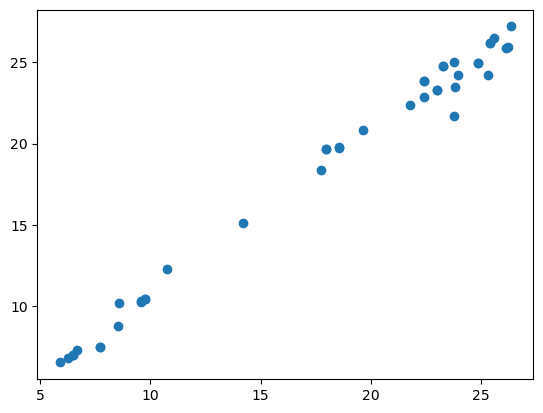

In [30]:
# visually check the matchups (see more sophisticted plots at the the end)
plt.plot(df_matchup_lxp_skin['insitu_temp_mean'],df_matchup_lxp_skin['ST'],'o')

### BUC skin

In [31]:
df_insitu = df_buc_skin.copy()
df_sat = df_buc_landsat.copy()

##################
timestamp_min = np.max([df_sat['timestamp'].iloc[0],df_insitu.index[0]])-3600*2
timestamp_max = np.min([df_sat['timestamp'].iloc[-1],df_insitu.index[-1]])+3600*2

df_insitu = df_insitu[(df_insitu.index>timestamp_min) & (df_insitu.index<timestamp_max)]
df_sat = df_sat[(df_sat['timestamp']>timestamp_min) & (df_sat['timestamp']<timestamp_max)]

df_sat['insitu_temp_mean'] = np.nan
df_sat['insitu_temp_median'] = np.nan
df_sat['insitu_temp_std'] = np.nan
df_sat['insitu_timestamp'] = np.nan

##################
for ii in range(len(df_sat)):
    ind_matchup = np.where(abs(df_sat['timestamp'].iloc[ii]-df_insitu.index)==min(abs(df_sat['timestamp'].iloc[ii]-df_insitu.index)))[0][0]
    df_sat['insitu_temp_mean'].iloc[ii] = df_insitu['skin_temp'].iloc[ind_matchup-6:ind_matchup+6].mean()
    df_sat['insitu_temp_median'].iloc[ii] = df_insitu['skin_temp'].iloc[ind_matchup-6:ind_matchup+6].median()
    df_sat['insitu_temp_std'].iloc[ii] = df_insitu['skin_temp'].iloc[ind_matchup-6:ind_matchup+6].std()
    df_sat['insitu_timestamp'] .iloc[ii] = df_insitu.index[ind_matchup]
    
##################
df_matchup_buc_skin = df_sat.copy()

C:\Users\claud\AppData\Local\Temp\ipykernel_15880\2161392771.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sat['insitu_temp_mean'].iloc[ii] = df_insitu['skin_temp'].iloc[ind_matchup-6:ind_matchup+6].mean()
C:\Users\claud\AppData\Local\Temp\ipykernel_15880\2161392771.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sat['insitu_temp_median'].iloc[ii] = df_insitu['skin_temp'].iloc[ind_matchup-6:ind_matchup+6].median()
C:\Users\claud\AppData\Local\Temp\ipykernel_15880\2161392771.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

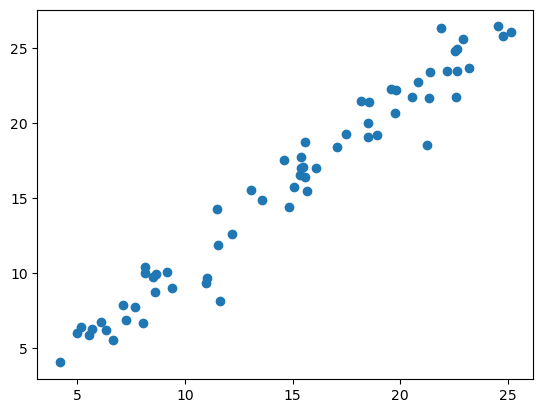

In [32]:
# visually check the matchups (see more sophisticted plots at the the end)
plt.plot(df_matchup_buc_skin['insitu_temp_mean'],df_matchup_buc_skin['ST'],'o')

### BUC bulk

In [33]:
df_insitu = df_buc_bulk.copy()
df_sat = df_buc_landsat.copy()

##################
timestamp_min = np.max([df_sat['timestamp'].iloc[0],df_insitu.index[0]])-3600*2
timestamp_max = np.min([df_sat['timestamp'].iloc[-1],df_insitu.index[-1]])+3600*2

df_insitu = df_insitu[(df_insitu.index>timestamp_min) & (df_insitu.index<timestamp_max)]
df_sat = df_sat[(df_sat['timestamp']>timestamp_min) & (df_sat['timestamp']<timestamp_max)]

df_sat['insitu_temp_mean'] = np.nan
df_sat['insitu_temp_median'] = np.nan
df_sat['insitu_temp_std'] = np.nan
df_sat['insitu_timestamp'] = np.nan

##################
for ii in range(len(df_sat)):
    ind_matchup = np.where(abs(df_sat['timestamp'].iloc[ii]-df_insitu.index)==min(abs(df_sat['timestamp'].iloc[ii]-df_insitu.index)))[0][0]
    df_sat['insitu_temp_mean'].iloc[ii] = df_insitu['bulk_temp'].iloc[ind_matchup-6:ind_matchup+6].mean()
    df_sat['insitu_temp_median'].iloc[ii] = df_insitu['bulk_temp'].iloc[ind_matchup-6:ind_matchup+6].median()
    df_sat['insitu_temp_std'].iloc[ii] = df_insitu['bulk_temp'].iloc[ind_matchup-6:ind_matchup+6].std()
    df_sat['insitu_timestamp'] .iloc[ii] = df_insitu.index[ind_matchup]
    
##################
df_matchup_buc_bulk = df_sat.copy()

C:\Users\claud\AppData\Local\Temp\ipykernel_15880\2581152619.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sat['insitu_temp_mean'].iloc[ii] = df_insitu['bulk_temp'].iloc[ind_matchup-6:ind_matchup+6].mean()
C:\Users\claud\AppData\Local\Temp\ipykernel_15880\2581152619.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sat['insitu_temp_median'].iloc[ii] = df_insitu['bulk_temp'].iloc[ind_matchup-6:ind_matchup+6].median()
C:\Users\claud\AppData\Local\Temp\ipykernel_15880\2581152619.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

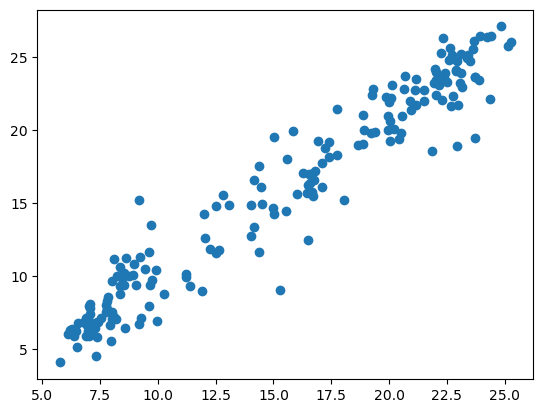

In [34]:
# visually check the matchups (see more sophisticted plots at the the end)
plt.plot(df_matchup_buc_bulk['insitu_temp_mean'],df_matchup_buc_bulk['ST'],'o')

# Plot the results

In [35]:
df_matchup_buc_bulk['stationN'] = 'BUC_bulk'
df_matchup_buc_skin['stationN'] = 'BUC_skin'
df_matchup_lxp_skin['stationN'] = 'LXP_skin'
df_matchup_lxp_skin

,ST,ST_unc,coverage,sensor,time_utc,time_utc+1,time_unix,timestamp,insitu_temp_mean,insitu_temp_median,insitu_temp_std,insitu_timestamp,stationN
system:index,,,,,,,,,,,,,
1_1_2_LE07_196028_20220309,6.561921,2.87,1.001916,LANDSAT_7,2022-03-09 09:03:51,2022-03-09 10:03:51,1646816631,1.646813e+09,5.898333,5.950,0.142499,1.646813e+09,LXP_skin
2_LC09_196027_20220309,7.040444,2.44,1.002077,LANDSAT_9,2022-03-09 10:22:43,2022-03-09 11:22:43,1646821363,1.646818e+09,6.475833,6.500,0.095295,1.646818e+09,LXP_skin
2_LC09_196028_20220309,7.040444,2.09,1.001916,LANDSAT_9,2022-03-09 10:23:07,2022-03-09 11:23:07,1646821387,1.646818e+09,6.475833,6.500,0.095295,1.646818e+09,LXP_skin
1_2_LC08_195028_20220310,7.354901,1.96,1.002077,LANDSAT_8,2022-03-10 10:16:53,2022-03-10 11:16:53,1646907413,1.646904e+09,6.663333,6.610,0.213513,1.646904e+09,LXP_skin
1_1_2_LE07_196028_20220325,8.773380,2.17,1.001916,LANDSAT_7,2022-03-25 09:02:17,2022-03-25 10:02:17,1648198937,1.648195e+09,8.535000,8.590,0.234113,1.648195e+09,LXP_skin
2_LC09_196027_20220325,10.297817,3.74,1.002077,LANDSAT_9,2022-03-25 10:22:38,2022-03-25 11:22:38,1648203758,1.648200e+09,9.590000,9.635,0.271662,1.648200e+09,LXP_skin
2_LC09_196028_20220325,10.314907,3.68,1.001916,LANDSAT_9,2022-03-25 10:23:02,2022-03-25 11:23:02,1648203782,1.648200e+09,9.590000,9.635,0.271662,1.648200e+09,LXP_skin
1_2_LC08_195028_20220326,10.208948,1.86,1.002077,LANDSAT_8,2022-03-26 10:16:41,2022-03-26 11:16:41,1648289801,1.648286e+09,8.577500,8.515,0.259549,1.648286e+09,LXP_skin
1_1_2_LE07_195028_20220403,6.838780,3.52,1.002077,LANDSAT_7,2022-04-03 08:55:14,2022-04-03 09:55:14,1648976114,1.648969e+09,6.250833,6.270,0.116733,1.648969e+09,LXP_skin


In [36]:
df_matchup_buc_bulk['sensor'].unique()

array(['LANDSAT_8', 'LANDSAT_7', 'LANDSAT_9'], dtype=object)

In [37]:
output_folder = 'G:/Trishna/Data/Geneva/skin_temp/'

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'H

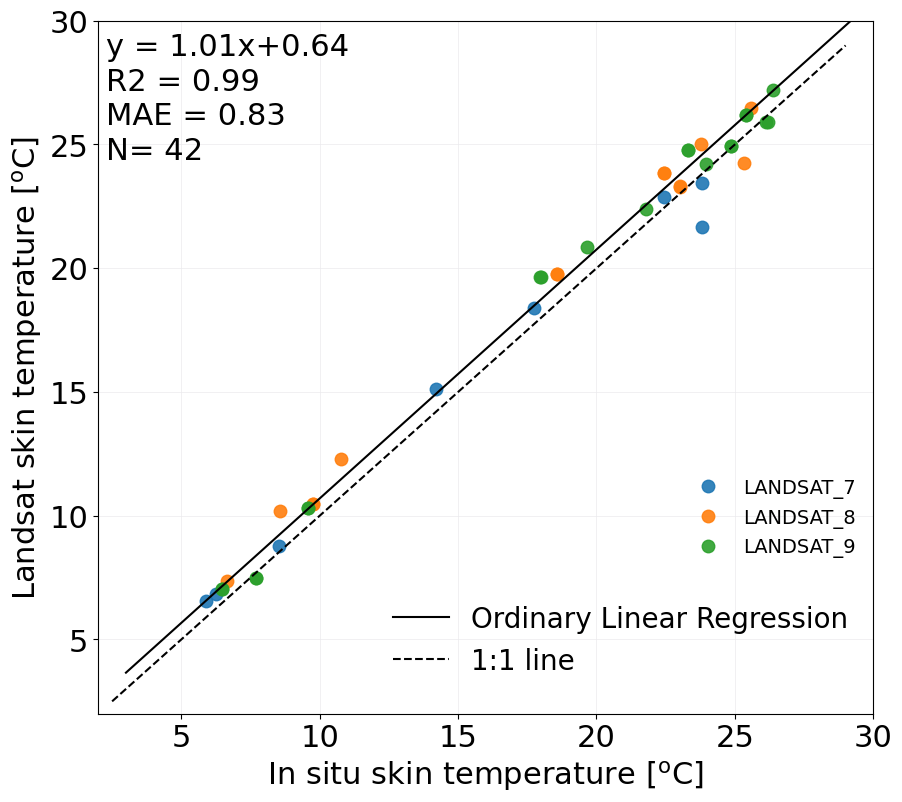

In [38]:
df_plt = df_matchup_lxp_skin.copy()

###############
fig_size = (10,9)
xy_lbl = ['$\mathregular{In \ situ  \ skin \ temperature \ [^oC]}$','$\mathregular{Landsat \ skin \ temperature \ [^oC]}$'] # [xlaebl, ylabel]
xtick_rotation = 0
font_feature = ['Helvetica', 22, 22] # [fontname, fontsize_labels, fontsize_ticks]
x_lim = [2,30]#[x[0],x[-1]]
x_lim_1l1 = [2,30]
bbox_anch1= 1.

# define the plotting columns. "value" is the in situ data.
in_situ_str = 'insitu_temp_mean'
s3_str = 'ST'

###############
df_plt[s3_str] = df_plt[s3_str].astype(float)

# implement some filters here, if neccessary

df_out = df_plt.copy()

xx = np.array(df_out[in_situ_str])
yy = np.array(df_out[s3_str])
mae_val = mean_absolute_error(xx, yy)
slope,intrp,rval,pval,stderr = stats.linregress( xx,yy)
slope,intrp = stats.siegelslopes(yy, xx)
corr_ceof = np.corrcoef(xx,yy)[0][1]

###############
fig = plt.figure(figsize=fig_size)
ax2 = fig.add_subplot(1,1,1)

plt.grid(color='#EBEAED', linestyle='-', linewidth=0.5)
plt.hold=True

station_names_all = np.array(['LANDSAT_7', 'LANDSAT_8', 'LANDSAT_9'])
plot_lines=[]
for ii in range(len(station_names_all)):
    str_plt=station_names_all[ii]
    if (len(df_out[df_out['sensor']==str_plt])>0):
        ln0=ax2.plot(np.array(df_out[df_out['sensor']==str_plt][in_situ_str]),np.array(df_out[df_out['sensor']==str_plt][s3_str]),'o',label=str_plt, markersize=9,alpha=0.9)
        plot_lines.append(ln0)

ln1 = ax2.plot(np.array([x_lim_1l1[0]+1,x_lim_1l1[1]-0.5]),slope*np.array([x_lim_1l1[0]+1,x_lim_1l1[1]-0.5])+intrp,'-',color='k') 
ln2 = ax2.plot(np.array([x_lim_1l1[0]+0.5,x_lim_1l1[1]-1]),np.array([x_lim_1l1[0]+0.5,x_lim_1l1[1]-1]),'--',color='k')

ax2.set_xlim(xmin=x_lim[0], xmax=x_lim[1])
ax2.set_ylim(ymin=x_lim[0], ymax=x_lim[1])
# ax2.set_title('All stations-Rw665>0 & No. pixels>=9', fontsize= font_feature[1],fontname=font_feature[0], loc='center')
if xtick_rotation != 0:
    plt.xticks(rotation=xtick_rotation, ha=u"right",fontname=font_feature[0],fontsize=font_feature[2])
else:
    plt.xticks(fontname=font_feature[0],fontsize=font_feature[2])
plt.yticks(fontname=font_feature[0],fontsize=font_feature[2])
ax2.set_xlabel(xy_lbl[0], fontsize= font_feature[1],fontname=font_feature[0])
ax2.set_ylabel(xy_lbl[1], fontsize= font_feature[1],fontname=font_feature[0])
ax2.annotate('y = '+'%1.2f' %slope+'x'+'%+1.2f' %intrp,xy=(0.01, 0.95), xycoords='axes fraction',fontname=font_feature[0],fontsize=font_feature[1])
ax2.annotate('R2 = '+'%0.2f' %corr_ceof**2,xy=(0.01, 0.9), xycoords='axes fraction',fontname=font_feature[0],fontsize=font_feature[2])
ax2.annotate('MAE = '+'%2.2f' %mae_val,xy=(0.01, 0.85), xycoords='axes fraction',fontname=font_feature[0],fontsize=font_feature[2])
ax2.annotate('N= '+'%1.0f' %len(xx),xy=(0.01, 0.8), xycoords='axes fraction',fontname=font_feature[0],fontsize=font_feature[2])

lines = plt.gca().get_lines()
include = range(len(plot_lines))
leg1 = plt.legend([lines[i] for i in include],[lines[i].get_label() for i in include],loc = 'lower right',facecolor = 'k',bbox_to_anchor=(bbox_anch1, 0.2),frameon=False, prop={"size":font_feature[1]-8,'family':font_feature[0]})
# plt.setp(leg.get_texts(), color='k')
leg2 =plt.legend([lines[i] for i in [len(plot_lines),len(plot_lines)+1]],['Ordinary Linear Regression','1:1 line'],loc = 'lower right',facecolor = 'k',bbox_to_anchor=(bbox_anch1, 0.02),frameon=False, prop={"size":font_feature[1]-2,'family':font_feature[0]})
plt.gca().add_artist(leg1)

# plt.savefig(output_folder+'matchups_landsat_LXP_skin_fixed.png',dpi=300, bbox_inches = 'tight')

plt.show()
plt.close()


# merge all matchups

In [39]:
df_matchup_all = pd.concat([df_matchup_lxp_skin,df_matchup_buc_skin,df_matchup_buc_bulk])
display(df_matchup_all)

,ST,ST_unc,coverage,sensor,time_utc,time_utc+1,time_unix,timestamp,insitu_temp_mean,insitu_temp_median,insitu_temp_std,insitu_timestamp,stationN
system:index,,,,,,,,,,,,,
1_1_2_LE07_196028_20220309,6.561921,2.87,1.001916,LANDSAT_7,2022-03-09 09:03:51,2022-03-09 10:03:51,1646816631,1.646813e+09,5.898333,5.950,0.142499,1.646813e+09,LXP_skin
2_LC09_196027_20220309,7.040444,2.44,1.002077,LANDSAT_9,2022-03-09 10:22:43,2022-03-09 11:22:43,1646821363,1.646818e+09,6.475833,6.500,0.095295,1.646818e+09,LXP_skin
2_LC09_196028_20220309,7.040444,2.09,1.001916,LANDSAT_9,2022-03-09 10:23:07,2022-03-09 11:23:07,1646821387,1.646818e+09,6.475833,6.500,0.095295,1.646818e+09,LXP_skin
1_2_LC08_195028_20220310,7.354901,1.96,1.002077,LANDSAT_8,2022-03-10 10:16:53,2022-03-10 11:16:53,1646907413,1.646904e+09,6.663333,6.610,0.213513,1.646904e+09,LXP_skin
1_1_2_LE07_196028_20220325,8.773380,2.17,1.001916,LANDSAT_7,2022-03-25 09:02:17,2022-03-25 10:02:17,1648198937,1.648195e+09,8.535000,8.590,0.234113,1.648195e+09,LXP_skin
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1_2_LC08_195028_20221004,12.499022,2.14,0.957916,LANDSAT_8,2022-10-04 10:17:31,2022-10-04 11:17:31,1664878651,1.664871e+09,16.497500,16.395,0.212779,1.664870e+09,BUC_bulk
1_1_2_LE07_195028_20221006,16.241753,3.53,0.957916,LANDSAT_7,2022-10-06 08:39:17,2022-10-06 09:39:17,1665045557,1.665038e+09,16.494167,16.440,0.199748,1.665040e+09,BUC_bulk
1_2_LC08_196028_20221011,17.219307,2.00,1.003421,LANDSAT_8,2022-10-11 10:23:36,2022-10-11 11:23:36,1665483816,1.665477e+09,16.790833,16.720,0.174432,1.665475e+09,BUC_bulk


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

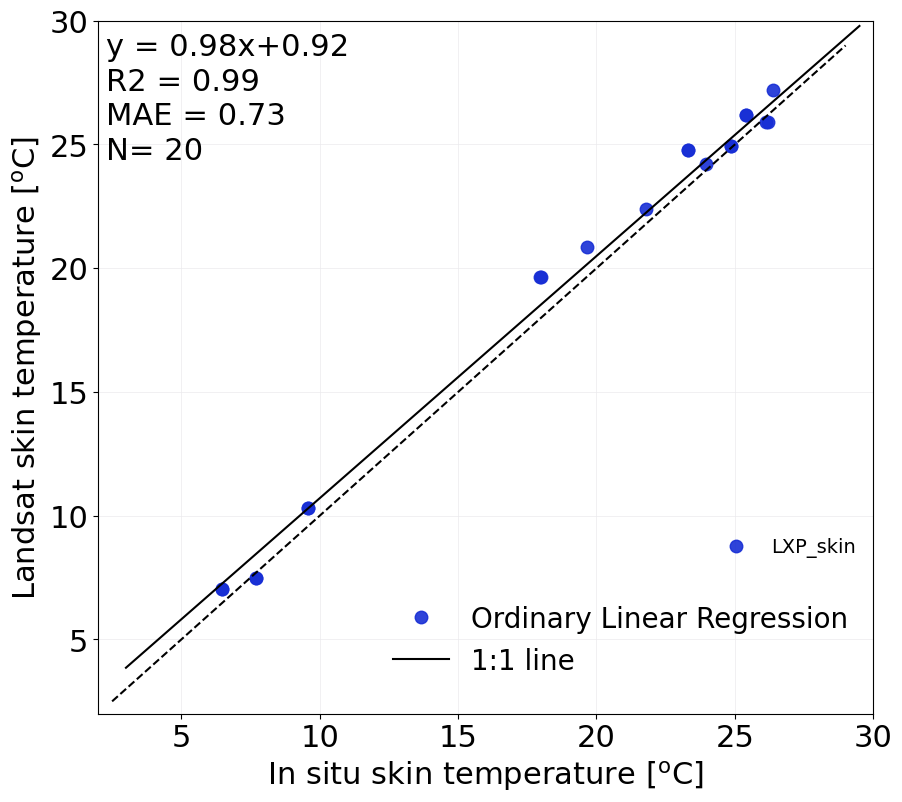

In [40]:
df_plt = df_matchup_all.copy()
# df_plt = df_plt[df_plt['sensor']=='LANDSAT_7']
df_plt = df_plt[(df_plt['sensor']=='LANDSAT_9') & (df_plt['stationN']!='BUC_bulk')]
color = ['#172ED5','#C38F0E','#000001']

###############
fig_size = (10,9)
xy_lbl = ['$\mathregular{In \ situ  \ skin \ temperature \ [^oC]}$','$\mathregular{Landsat \ skin \ temperature \ [^oC]}$'] # [xlaebl, ylabel]
xtick_rotation = 0
font_feature = ['Helvetica', 22, 22] # [fontname, fontsize_labels, fontsize_ticks]
x_lim = [2,30]#[x[0],x[-1]]
x_lim_1l1 = [2,30]
bbox_anch1= 1.

# define the plotting columns. "value" is the in situ data.
in_situ_str = 'insitu_temp_mean'
s3_str = 'ST'

###############
df_plt[s3_str] = df_plt[s3_str].astype(float)

# implement some filters here, if neccessary

df_out = df_plt.copy()

xx = np.array(df_out[in_situ_str])
yy = np.array(df_out[s3_str])
mae_val = mean_absolute_error(xx, yy)
slope,intrp,rval,pval,stderr = stats.linregress( xx,yy)
slope,intrp = stats.siegelslopes(yy, xx)
corr_ceof = np.corrcoef(xx,yy)[0][1]

###############
fig = plt.figure(figsize=fig_size)
ax2 = fig.add_subplot(1,1,1)

plt.grid(color='#EBEAED', linestyle='-', linewidth=0.5)
plt.hold=True

station_names_all = df_out['stationN'].unique()
plot_lines=[]
for ii in range(len(station_names_all)):
    str_plt=station_names_all[ii]
    if (len(df_out[df_out['stationN']==str_plt])>0):
        lower_error = np.array(df_out[df_out['stationN']==str_plt]['ST_unc'])
        upper_error = np.array(df_out[df_out['stationN']==str_plt]['ST_unc'])
        asymmetric_error = [lower_error, upper_error]
#         ax2.errorbar(np.array(df_out[df_out['stationN']==str_plt][in_situ_str]),np.array(df_out[df_out['stationN']==str_plt][s3_str]),yerr=asymmetric_error,fmt='o',color=color[ii],elinewidth=2,capsize=5,capthick=2,barsabove=True, markersize=9,alpha=0.9)
        ln0=ax2.plot(np.array(df_out[df_out['stationN']==str_plt][in_situ_str]),np.array(df_out[df_out['stationN']==str_plt][s3_str]),'o',color=color[ii],label=str_plt, markersize=9,alpha=0.9)
        plot_lines.append(ln0)

ln1 = ax2.plot(np.array([x_lim_1l1[0]+1,x_lim_1l1[1]-0.5]),slope*np.array([x_lim_1l1[0]+1,x_lim_1l1[1]-0.5])+intrp,'-',color='k') 
ln2 = ax2.plot(np.array([x_lim_1l1[0]+0.5,x_lim_1l1[1]-1]),np.array([x_lim_1l1[0]+0.5,x_lim_1l1[1]-1]),'--',color='k')

ax2.set_xlim(xmin=x_lim[0], xmax=x_lim[1])
ax2.set_ylim(ymin=x_lim[0], ymax=x_lim[1])
# ax2.set_title('All stations-Rw665>0 & No. pixels>=9', fontsize= font_feature[1],fontname=font_feature[0], loc='center')
if xtick_rotation != 0:
    plt.xticks(rotation=xtick_rotation, ha=u"right",fontname=font_feature[0],fontsize=font_feature[2])
else:
    plt.xticks(fontname=font_feature[0],fontsize=font_feature[2])
plt.yticks(fontname=font_feature[0],fontsize=font_feature[2])
ax2.set_xlabel(xy_lbl[0], fontsize= font_feature[1],fontname=font_feature[0])
ax2.set_ylabel(xy_lbl[1], fontsize= font_feature[1],fontname=font_feature[0])
ax2.annotate('y = '+'%1.2f' %slope+'x'+'%+1.2f' %intrp,xy=(0.01, 0.95), xycoords='axes fraction',fontname=font_feature[0],fontsize=font_feature[1])
ax2.annotate('R2 = '+'%0.2f' %corr_ceof**2,xy=(0.01, 0.9), xycoords='axes fraction',fontname=font_feature[0],fontsize=font_feature[2])
ax2.annotate('MAE = '+'%2.2f' %mae_val,xy=(0.01, 0.85), xycoords='axes fraction',fontname=font_feature[0],fontsize=font_feature[2])
ax2.annotate('N= '+'%1.0f' %len(xx),xy=(0.01, 0.8), xycoords='axes fraction',fontname=font_feature[0],fontsize=font_feature[2])


lines = plt.gca().get_lines()
leg_list = np.array([lines[i].get_label() for i in range(len(lines))])
ind_lines = np.where(leg_list!='_nolegend_')[0][:-2]

include = range(len(plot_lines))
leg1 = plt.legend([lines[i] for i in ind_lines],leg_list[ind_lines],loc = 'lower right',facecolor = 'k',bbox_to_anchor=(bbox_anch1, 0.2),frameon=False, prop={"size":font_feature[1]-8,'family':font_feature[0]})
# plt.setp(leg.get_texts(), color='k')
leg2 =plt.legend([lines[i] for i in [len(plot_lines)-4,len(plot_lines)-3]],['Ordinary Linear Regression','1:1 line'],loc = 'lower right',facecolor = 'k',bbox_to_anchor=(bbox_anch1, 0.02),frameon=False, prop={"size":font_feature[1]-2,'family':font_feature[0]})
plt.gca().add_artist(leg1)

# plt.savefig(output_folder+'matchups_landsat9_all_wo_errorbar_onlyskin.png',dpi=300, bbox_inches = 'tight')

plt.show()
plt.close()
